# Start

In [2]:
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.d_model = d_model
        
        self.encoder = nn.Embedding(ntoken, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.decoder = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output


def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [3]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [4]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# train_iter was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into bsz separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Args:
        data: Tensor, shape [N]
        bsz: int, batch size

    Returns:
        Tensor of shape [N // bsz, bsz]
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # shape [seq_len, batch_size]
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

In [12]:
print(train_data.shape)
train_data[:5]

torch.Size([102499, 20])


tensor([[    9,    59,   564,   223,   443, 13627,     2,   539,  2872,  2464,
             0,   313,  4513,     1,     5,    47,    66, 11652,  2435,     1],
        [ 3849,    12,   300,  6302,  3989,  1930, 10559,   451,     4,     7,
             2,  1511, 10115,   942,  2439,   572,     1,    47,    30,  1990],
        [ 3869,   315,    19,    29,   939,     2,    10,  2139,  4916, 16615,
           235,     3,    13,     7,    24,    17, 13737,    97,  7720,     4],
        [  881,    67,   807,  5402,     6,    38, 28188,    25,     2,    77,
             7,  2394,    17,   516,    14, 16403,  3714,  4618,    12,  1108],
        [    9,   196,  6041,   190,   218, 11776,    17,     1,  1200,     2,
             0,    10,   591,    40,  6004,     2,    50,     3,  3131,  3781]],
       device='cuda:0')

In [13]:
print(val_data.shape)
val_data[:5]

torch.Size([21441, 10])


tensor([[    9,     7,  1934,   340,     3,     1,   148,  2154,   349,    32],
        [ 9606,     1, 18113,     7,     9,   133,     7,   126,    51,  3490],
        [25610,   110,   256,  7570,  1004,  3660,   845,    20,     8,    56],
        [    9,   186,    11,     1,     6,    16,     1,  2877,   654,  1748],
        [ 9606,  3049,    15,   146,  1289,     2,    67,   339,     4,     3]],
       device='cuda:0')

In [5]:
bptt = 35
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape [full_seq_len, batch_size]
        i: int

    Returns:
        tuple (data, target), where data has shape [seq_len, batch_size] and
        target has shape [seq_len * batch_size]
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [6]:
ntokens = len(vocab)  # size of vocabulary
emsize = 200  # embedding dimension
d_hid = 200  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # number of heads in nn.MultiheadAttention
dropout = 0.2  # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

In [14]:
ntokens

28782

In [18]:
print(train_data[:35].shape)
model.encoder(train_data[:35]).shape

torch.Size([35, 20])


torch.Size([35, 20, 200])

In [27]:
model.pos_encoder.pe[:35].shape

torch.Size([35, 1, 200])

In [24]:
model.pos_encoder(model.encoder(train_data[:35]) * math.sqrt(model.d_model))

tensor([[[-0.7289,  1.8346,  0.4786,  ...,  1.4639, -1.4171,  0.0813],
         [-0.8794, -0.1175,  1.4903,  ...,  0.2706, -0.8367, -0.3261],
         [ 0.0000,  0.9132,  0.4607,  ...,  0.3973,  0.4494,  1.7791],
         ...,
         [ 0.0650,  0.0000,  1.1919,  ...,  0.0000, -1.4340,  0.3072],
         [-1.2031, -0.4692,  1.4120,  ...,  0.4051, -1.3769,  2.4646],
         [ 0.8749,  0.7204,  1.2893,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 2.4131,  0.0000,  0.0000,  ...,  2.6297, -1.5589,  0.2041],
         [ 0.0000,  0.0508,  0.7145,  ...,  1.1957, -1.7035, -0.1074],
         [ 1.2993,  0.1980,  0.0000,  ...,  0.2091,  0.0000,  0.0000],
         ...,
         [ 1.7394,  0.0000,  1.2292,  ...,  1.1448, -0.1162,  0.0000],
         [ 1.8246,  0.0000,  2.4204,  ...,  0.1613,  0.7780,  0.0000],
         [ 1.5124,  1.2966,  1.1471,  ...,  1.2086, -1.3884,  1.3919]],

        [[ 0.0000, -0.9334, -0.5322,  ...,  1.8138,  0.5712,  0.0000],
         [ 2.5898, -0.0424,  0.5627,  ...,  1

In [7]:
import copy
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(bptt).to(device)

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        batch_size = data.size(0)
        if batch_size != bptt:  # only on last batch
            src_mask = src_mask[:batch_size, :batch_size]
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            batch_size = data.size(0)
            if batch_size != bptt:
                src_mask = src_mask[:batch_size, :batch_size]
            output = model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += batch_size * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

In [ ]:
best_val_loss = float('inf')
epochs = 3
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model)
    val_loss = evaluate(model, val_data)
    val_ppl = math.exp(val_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)

    scheduler.step()

In [ ]:
test_loss = evaluate(best_model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

In [1]:
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
#         em_src = self.encoder(src) * math.sqrt(self.d_model)
        pos_src = self.pos_encoder(src * math.sqrt(self.d_model))
        output_trans = self.transformer_encoder(pos_src, src_mask)
        output_final = self.decoder(output_trans)
        return pos_src, output_trans, output_final


def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [41]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [42]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# train_iter was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [43]:
train_data.shape, train_data.type()

(torch.Size([2049990]), 'torch.LongTensor')

In [44]:
def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into bsz separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Args:
        data: Tensor, shape [N]
        bsz: int, batch size

    Returns:
        Tensor of shape [N // bsz, bsz]
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # shape [seq_len, batch_size]
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

In [45]:
train_data.size()

torch.Size([102499, 20])

In [46]:
bptt = 35
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape [full_seq_len, batch_size]
        i: int

    Returns:
        tuple (data, target), where data has shape [seq_len, batch_size] and
        target has shape [seq_len * batch_size]
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [58]:
ntokens = 1024  # size of vocabulary
d_model = 768  # embedding dimension
nhead = 2  # number of heads in nn.MultiheadAttention
d_hid = 768  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
dropout = 0.2  # dropout probability
model = TransformerModel(ntokens, d_model, nhead, d_hid, nlayers, dropout).to(device)

In [9]:
# for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
#     data, targets = get_batch(train_data, i)
#     print(data.size())
#     print(targets.size())
#     batch_size = data.size(0)

In [10]:
num_batches = len(train_data) // bptt
num_batches

2928

In [11]:
# train_data[:35].shape

In [ ]:
# transformed_dataset[0]['sentence_embeddings'][:40].type(torch.FloatTensor).to(device)

In [13]:
# src_mask = generate_square_subsequent_mask(35).to(device)
# model.train()
# em_src, pos_src, output = model(train_data[:35], None)  # transformed_dataset[0]['sentence_embeddings'][:35].to(device)

In [15]:
train_data[:35]

tensor([[    9,    59,   564,   223,   443, 13627,     2,   539,  2872,  2464,
             0,   313,  4513,     1,     5,    47,    66, 11652,  2435,     1],
        [ 3849,    12,   300,  6302,  3989,  1930, 10559,   451,     4,     7,
             2,  1511, 10115,   942,  2439,   572,     1,    47,    30,  1990],
        [ 3869,   315,    19,    29,   939,     2,    10,  2139,  4916, 16615,
           235,     3,    13,     7,    24,    17, 13737,    97,  7720,     4],
        [  881,    67,   807,  5402,     6,    38, 28188,    25,     2,    77,
             7,  2394,    17,   516,    14, 16403,  3714,  4618,    12,  1108],
        [    9,   196,  6041,   190,   218, 11776,    17,     1,  1200,     2,
             0,    10,   591,    40,  6004,     2,    50,     3,  3131,  3781],
        [20000,    21,  6406,    14,     3,    10,     8,   114,    24,  2294,
          1684,  7156,  1681,   191,   928,  5879,    51,     9,  1147,     5],
        [   83,     8,     2,  1019,  1817,   

## Debug Positional Encoding with my dataset

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [88]:
position = torch.arange(5000).unsqueeze(1)
div_term = torch.exp(torch.arange(0, 768, 2) * (-math.log(10000.0) / 768))
pe = torch.zeros(5000, 1, 768)
pe[:, 0, 0::2] = torch.sin(position * div_term)
pe[:, 0, 1::2] = torch.cos(position * div_term)

In [92]:
pe[:1].shape

torch.Size([1, 1, 768])

#### remember to convert the type to FloatTensor => .type(torch.FloatTensor)

In [28]:
transformed_dataset[0]['sentence_embeddings'].type(torch.FloatTensor)[:50]

tensor([[-0.0131,  0.0572, -0.0360,  ..., -0.0415, -0.0471,  0.0127],
        [-0.0290,  0.0563, -0.0076,  ..., -0.0085, -0.0270, -0.0027],
        [ 0.0337, -0.0226, -0.0394,  ...,  0.0040, -0.0337, -0.0060],
        ...,
        [-0.0279,  0.0281,  0.0023,  ..., -0.0149,  0.0905, -0.0053],
        [-0.0013,  0.0304, -0.0268,  ..., -0.0260,  0.0886, -0.0083],
        [ 0.0515, -0.0140, -0.0373,  ...,  0.0157,  0.0309,  0.0181]])

In [69]:
pe[:50].shape

torch.Size([50, 1, 768])

In [29]:
(transformed_dataset[0]['sentence_embeddings'].type(torch.FloatTensor)[:1] + pe[:1]).shape

torch.Size([50, 50, 768])

### Debug: give the dataset to model 

In [59]:
src_mask = generate_square_subsequent_mask(50).to(device)
model.train()
pos_src, output_trans, output_final = model(transformed_dataset[0]['sentence_embeddings'].type(torch.FloatTensor)[:50].to(device),
                                            src_mask)

In [49]:
src_mask.size()

torch.Size([50, 50])

In [60]:
print(pos_src.size())
# pos_src

torch.Size([50, 50, 768])


In [61]:
print(output_trans.size())

torch.Size([50, 50, 768])


In [62]:
output_final.shape

torch.Size([50, 50, 1024])

In [40]:
output.view(-1).shape

torch.Size([2560000])

# Train and Evaluate

In [ ]:
import copy
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(bptt).to(device)

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        batch_size = data.size(0)
        if batch_size != bptt:  # only on last batch
            src_mask = src_mask[:batch_size, :batch_size]
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            batch_size = data.size(0)
            if batch_size != bptt:
                src_mask = src_mask[:batch_size, :batch_size]
            output = model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += batch_size * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

In [ ]:
best_val_loss = float('inf')
epochs = 3
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model)
    val_loss = evaluate(model, val_data)
    val_ppl = math.exp(val_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)

    scheduler.step()

In [ ]:
test_loss = evaluate(best_model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)


# Get the my dataset

In [1]:
import os
import numpy as np
import pandas as pd
from skimage import transform
from sentence_transformers import SentenceTransformer

import torch
from torch.utils.data import Dataset

In [99]:
def minmax_scaler(data):
    '''recale the data, which is a 2D matrix, to 0-1'''
    return (data - data.min(axis=1)[:, np.newaxis]) / (data.max(axis=1) - data.min(axis=1))[:, np.newaxis]


class DepressionDataset(Dataset):
    '''create a training, develop, or test dataset
       and load the participant features if it's called
    '''

    def __init__(self,
                 root_dir,
                 mode,
                 transform=None):
        super(DepressionDataset, self).__init__()

        # only train, develop, test dataset allow
        assert mode in ["train", "validation", "test"], \
            "Argument --mode could only be ['train', 'validation', 'test']"

        self.mode = mode
        self.root_dir = root_dir
        self.transform = transform
        self.train_data_path = os.path.join(self.root_dir, 'train_split_Depression_AVEC2017.csv')
        self.valid_data_path = os.path.join(self.root_dir, 'dev_split_Depression_AVEC2017.csv')
        self.test_data_path = os.path.join(self.root_dir, 'full_test_split.csv')
        # load sent2vec model for converting text file to 2D array
        self.sent2vec = SentenceTransformer('all-mpnet-base-v2')  # output dimension 768

        # load training data # 107 sessions
        if self.mode == "train":
            # pre-checking and cleaning the data
            self.data_df = self.pre_check(pd.read_csv(self.train_data_path))
            # store ground truth
            ####################################################################################################
            # self.patientIDs = self.data_df['Participant_ID'].to_numpy()
            self.patientIDs = np.array([303, 321, 362, 363, 426])  # for debugging on my laptop
            ####################################################################################################
            self.phq_binay_gt = self.data_df['PHQ8_Binary'].to_numpy()
            self.phq_score_gt = self.data_df['PHQ8_Score'].to_numpy()
            self.gender_gt = self.data_df['Gender'].to_numpy()
            self.phq_subscores_gt = self.data_df.iloc[:, 4:].to_numpy()

        # load development data # 35 sessions
        if self.mode == "validation":
            # pre-checking and cleaning the data
            self.data_df = self.pre_check(pd.read_csv(self.valid_data_path))
            # store ground truth
            self.patientIDs = self.data_df['Participant_ID'].to_numpy()
            self.phq_binay_gt = self.data_df['PHQ8_Binary'].to_numpy()
            self.phq_score_gt = self.data_df['PHQ8_Score'].to_numpy()
            self.gender_gt = self.data_df['Gender'].to_numpy()
            self.phq_subscores_gt = self.data_df.iloc[:, 4:].to_numpy()

        # load test data # 47 sessions
        if self.mode == "test":
            # pre-checking and cleaning the data
            self.data_df = self.pre_check(pd.read_csv(self.test_data_path))
            # store ground truth
            self.patientIDs = self.data_df['Participant_ID'].to_numpy()
            self.phq_binay_gt = self.data_df['PHQ_Binary'].to_numpy()
            self.phq_score_gt = self.data_df['PHQ_Score'].to_numpy()
            self.gender_gt = self.data_df['Gender'].to_numpy()
            self.phq_subscores_gt = None

    def pre_check(self, data):
        '''
        Basic cleaning process to make sure no missing value
        and that the sum of each PHQ subscore equals to PHQ score
        Argument:
            data: numpy array
        Return:
            data: numpy array with type "int"
        '''
        # make sure no NaN, Inf, -Inf
        if data.isin([np.nan, np.inf, -np.inf]).any(1).sum():
            print('Replacing NaN, Inf, or -Inf ...')
            data = data.replace([np.inf, -np.inf, np.nan], 0)  # .astype('int')
        else:
            data = data  # .astype('int')

        # compare the sum of each PHQ subscore to PHQ score
        unequal = data.iloc[:, 4:].sum(axis=1) != data.iloc[:, 2]
        if unequal.any() and self.mode != 'test':
            lines = np.where(unequal)
            raise ValueError(("The sum of each PHQ subscore at line {} "
                              "is unequal to the PHQ score").format(lines[0]))

        return data

    def __len__(self):
        return len(self.patientIDs)

    def __iter__(self):
        return iter(self.patientIDs)

    def __getitem__(self, idx):
        '''
        Essentional function for creating dataset in PyTorch, which will automatically be
        called in Dataloader and load all the extracted features of the patient in the Batch
        based on the index of self.patientIDs
        Argument:
            idx: int, index of the patient ID in self.patientIDs
        Return:
            session: dict, contains all the extracted features and ground truth of a patient/session
        '''
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # get the patient session path
        session_num = self.patientIDs[idx]
        session_path = os.path.join(self.root_dir, '{}_P'.format(session_num))

        # TODO: if other feature is needed, add more in the following part...

        # get text path
        text_path = os.path.join(session_path, '{}_TRANSCRIPT.csv'.format(session_num))

        # text feature
        self.text_feature = self.load_sent2vec(text_path, speaker='Participant')
        sentence_embedding = self.text_feature['sentence_embeddings']

        # summary
        session = {'patientID': session_num,
                   'session_path': session_path,
                   'sentence_embeddings': sentence_embedding,
                   'phq_score_gt': self.phq_score_gt[idx],
                   'phq_binay_gt': self.phq_binay_gt[idx],
                   'phq_subscores_gt': self.phq_subscores_gt[idx],
                   'gender_gt': self.gender_gt[idx]}

        if self.transform:
            session = self.transform(session)

        return session

    def load_sent2vec(self, text_path, speaker='Participant'):
        '''
        load the text file and use sent2vec model from SentenceTransformer
        for sentence embeddings, which generates 2D array
        Arguments:
            text_path: string, absolute path to transcipt file
            speaker: certain string, which transcript of the speaker to load
        Return:
            text_feature: dict, contain converted embedding vectors, sentences, etc.
        '''

        # only 'Ellie', 'Participant', 'both' are allow
        assert speaker in ['Ellie', 'Participant', 'both'], \
            "Argument --speaker could only be ['Ellie', 'Participant', 'both']"

        text_file = pd.read_csv(text_path)
        # tokenize the text file, filter out all \t space and unnecessary columns such as time, participent
        tokenized_words = self.tokenize_corpus(text_file.values.tolist()[i][0] for i in range(text_file.shape[0]))

        sentences = []
        sentences_idx = []

        if speaker == 'Ellie':
            for idx, sentence in enumerate(tokenized_words):
                if sentence[2] == 'Ellie':
                    sentences.append(sentence[3:])
                    sentences_idx.append(idx)
        elif speaker == 'Participant':
            for idx, sentence in enumerate(tokenized_words):
                if sentence[2] == 'Participant':
                    sentences.append(sentence[3:])
                    sentences_idx.append(idx)

        else:  # speaker == 'both'
            sentences = [tokenized_words[i][3:] for i in range(len(tokenized_words))]
            sentences_idx = list(range(len(tokenized_words)))

        # recombine 2D list of words into 1D list of sentence
        final_sentences = [" ".join(sentences[i]).lower() for i in range(len(sentences))]
        # convert sentence to vector with SentenceTransformer pretrained model
        sentence_embeddings = self.sent2vec.encode(final_sentences)
        h, w = sentence_embeddings.shape  # num_sentences x 768
        sentence_embeddings = minmax_scaler(sentence_embeddings).reshape(h, int(w/3), 3)  # num_sentences x 256 x 3
        # summary
        text_feature = {'speaker': speaker,
                        'sentence_embeddings': sentence_embeddings,
                        'sentences': final_sentences,
                        'indices': sentences_idx}

        return text_feature

    def tokenize_corpus(self, corpus):
        '''tokenzie a given list of string into list of words
        Argument:
            corpus: 1D list of string, each element is a sting of sentence
        Return:
            tokens: 2D list of string, each raw is a list of words splitted from sentence
        '''
        tokens = [x.split() for x in corpus]
        return tokens


class Padding(object):
    ''' pad zero to each feature matrix so that they all have the same size '''

    def __init__(self, text_output_size=(386, 768)):
        super(Padding, self).__init__()
        '''
        Each output size could be 'int' or 'tuple'. 
        Integer would be the number of desired rows
        and Tuple would be the desired 2D array size.

        Here is recommended to keep the number of columns 
        as they are and only set the number of rows with int

        To find the maximum length of rows, please use the 
        'find_max_length' function in utils to search through. 

        The value 386 are the maximum length in our case.
        '''
        assert isinstance(text_output_size, (int, tuple))
        self.text_output_size = text_output_size

    def __call__(self, session):
        sentence_embeddings = session['sentence_embeddings']

        # text padding
        if isinstance(self.text_output_size, int):
            shape = sentence_embeddings.shape
            assert self.text_output_size >= shape[0], \
                "audio output size should be bigger than {}".format(shape[0])
            padded_text = np.zeros((self.text_output_size, shape[1]))
            padded_text[:shape[0], :shape[1]] = sentence_embeddings
        else:
            shape = sentence_embeddings.shape
            assert self.text_output_size[0] >= shape[0] and self.text_output_size[1] >= shape[1], \
                "text output size should be bigger than {}".format(shape)
            padded_text = np.zeros(self.text_output_size)
            padded_text[:shape[0], :shape[1]] = sentence_embeddings

        # summary
        padded_session = {'patientID': session['patientID'],
                          'session_path': session['session_path'],
                          'sentence_embeddings': padded_text,
                          'phq_score_gt': session['phq_score_gt'],
                          'phq_binay_gt': session['phq_binay_gt'],
                          'phq_subscores_gt': session['phq_subscores_gt'],
                          'gender_gt': session['gender_gt']}

        return padded_session


class Rescale(object):
    """Rescale the image in a sample to a given size.
    Arguments:
        output_size:(tuple or int),  Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size=(256, 256)):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, session):
        sentence_embeddings = session['sentence_embeddings']

        h, w = sentence_embeddings.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        rescaled_sentence_embeddings = transform.resize(sentence_embeddings, (new_h, new_w))

        # summary
        rescaled_session = {'patientID': session['patientID'],
                            'session_path': session['session_path'],
                            'sentence_embeddings': rescaled_sentence_embeddings,
                            'phq_score_gt': session['phq_score_gt'],
                            'phq_binay_gt': session['phq_binay_gt'],
                            'phq_subscores_gt': session['phq_subscores_gt'],
                            'gender_gt': session['gender_gt']}

        return rescaled_session


class RandomCrop(object):
    """Crop randomly the image in a sample.
    Arguments:
        output_size:(tuple or int), Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size=(224, 224)):
        assert isinstance(output_size, (int, tuple))

        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, session):
        sentence_embeddings = session['sentence_embeddings']

        h, w = sentence_embeddings.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        cropped_sentence_embeddings = sentence_embeddings[top:top + new_h, left:left + new_w]

        # summary
        cropped_session = {'patientID': session['patientID'],
                           'session_path': session['session_path'],
                           'sentence_embeddings': cropped_sentence_embeddings,
                           'phq_score_gt': session['phq_score_gt'],
                           'phq_binay_gt': session['phq_binay_gt'],
                           'phq_subscores_gt': session['phq_subscores_gt'],
                           'gender_gt': session['gender_gt']}

        return cropped_session


class ToTensor(object):
    """Convert ndarrays in sample to Tensors or np.int to torch.tensor."""

    def __call__(self, session):
        converted_session = {'patientID': session['patientID'],
                             'session_path': session['session_path'],
                             'sentence_embeddings': torch.from_numpy(session['sentence_embeddings']).type(
                                 torch.FloatTensor),
                             'phq_score_gt': torch.tensor(session['phq_score_gt']).type(torch.FloatTensor),
                             'phq_binay_gt': torch.tensor(session['phq_binay_gt']).type(torch.FloatTensor),
                             'phq_subscores_gt': torch.from_numpy(session['phq_subscores_gt']).type(torch.FloatTensor),
                             'gender_gt': torch.tensor(session['gender_gt']).type(torch.FloatTensor)}

        return converted_session


# Get DataLoader and see how it is loaded

In [100]:
from torch.utils.data import DataLoader
from torchvision import transforms

# test 3: try to load the dataset with DataLoader
transformed_dataset = DepressionDataset(os.path.join(os.getcwd(), 'DAIC-WOZ Dataset'), 'train',
                                        transform=transforms.Compose([Rescale((256, 256)),
                                                                      RandomCrop((224, 224)),
                                                                      ToTensor()]))

# create dataloader
dataloader = DataLoader(transformed_dataset, 
                        batch_size=2,
                        shuffle=False, 
                        num_workers=0)
# iterate through batches
for i_batch, sample_batched in enumerate(dataloader):
    print('Batch number: ', i_batch, ', sentence embeddings: ', sample_batched['sentence_embeddings'].size())
    print(sample_batched)
    print('=================================')
    
    if i_batch == 0:
        sample = sample_batched['sentence_embeddings']
    
print('number of the batches in DataLoader is {}'.format(len(dataloader)))

Batch number:  0 , sentence embeddings:  torch.Size([2, 224, 224, 3])
{'patientID': tensor([303, 321], dtype=torch.int32), 'session_path': ['C:\\Users\\denni\\Documents\\KIT Studium\\Bachelorarbeit\\DAIC-WOZ Dataset\\303_P', 'C:\\Users\\denni\\Documents\\KIT Studium\\Bachelorarbeit\\DAIC-WOZ Dataset\\321_P'], 'sentence_embeddings': tensor([[[[0.4850, 0.6227, 0.5460],
          [0.5285, 0.7611, 0.5326],
          [0.5800, 0.5206, 0.4511],
          ...,
          [0.5150, 0.5077, 0.5798],
          [0.5653, 0.4846, 0.2573],
          [0.4302, 0.3795, 0.4945]],

         [[0.5560, 0.5559, 0.4355],
          [0.5785, 0.8480, 0.4720],
          [0.4077, 0.5092, 0.5353],
          ...,
          [0.5497, 0.4464, 0.5438],
          [0.5685, 0.5042, 0.2923],
          [0.4463, 0.4576, 0.4820]],

         [[0.5627, 0.5251, 0.3599],
          [0.5938, 0.8525, 0.4618],
          [0.3178, 0.5030, 0.5507],
          ...,
          [0.5550, 0.4326, 0.5113],
          [0.5889, 0.4786, 0.3421],
     

In [102]:
sample.shape

torch.Size([2, 224, 224, 3])

####  use 'permute' to make sure the channel dimension is in 2 position to match the input requirement format

In [106]:
sample.permute(0, 3, 1, 2).contiguous().shape

torch.Size([2, 3, 224, 224])

##### remember to convert to torch.FloatTensor in order to fit in the model

In [4]:
transformed_dataset[0]['sentence_embeddings']  # .type(torch.DoubleTensor)

tensor([[-0.0131,  0.0572, -0.0360,  ..., -0.0415, -0.0471,  0.0127],
        [-0.0290,  0.0563, -0.0076,  ..., -0.0085, -0.0270, -0.0027],
        [ 0.0337, -0.0226, -0.0394,  ...,  0.0040, -0.0337, -0.0060],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       dtype=torch.float64)

In [5]:
transformed_dataset[0]['sentence_embeddings'].type(torch.FloatTensor).shape  # .type(torch.cuda.DoubleTensor)

torch.Size([386, 768])

### How list.extend() and torchElement.item() and torchVector.numpy() works

In [30]:
a_list = []
torch.tensor([2,3]).numpy()

array([2, 3], dtype=int64)

##### 2 ways to do it

In [414]:
a_list.extend(torch.tensor([2,3]).numpy())
a_list

[2, 3]

In [417]:
a_list.extend([i.item() for i in torch.tensor([2,3])])
a_list

[2, 3]

In [33]:
b_list = []
exp2 = torch.tensor([[2],[3]])
exp2

tensor([[2],
        [3]])

In [388]:
b_list.extend([i.item() for i in exp2])
b_list

[2, 3]

In [420]:
b_list.extend(exp2.numpy())
b_list

[array([2], dtype=int64), array([3], dtype=int64)]

### How to extend a torch tensor to a single list of float or list of numpy array

In [28]:
exp = torch.tensor([[0, 1, 1, 2, 2, 1, 0, 0],
                    [1, 1, 0, 0, 0, 1, 1, 0]])
exp

tensor([[0, 1, 1, 2, 2, 1, 0, 0],
        [1, 1, 0, 0, 0, 1, 1, 0]])

In [349]:
for i in exp:
    print(i.numpy())
    print(type(i.numpy()))

[0 1 1 2 2 1 0 0]
<class 'numpy.ndarray'>
[1 1 0 0 0 1 1 0]
<class 'numpy.ndarray'>


In [31]:
for i in exp:
    a_list.extend(i.numpy().astype(float))
a_list

[0.0,
 1.0,
 1.0,
 2.0,
 2.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0]

In [395]:
a_list.extend([exp[i].numpy().astype(float) for i in range(exp.size(0))])
a_list

[array([0., 1., 1., 2., 2., 1., 0., 0.]),
 array([1., 1., 0., 0., 0., 1., 1., 0.])]

In [379]:
# convet the whole list of numpy arrays to numpy arrays
np.array(a_list)

array([[0., 1., 1., 2., 2., 1., 0., 0.],
       [1., 1., 0., 0., 0., 1., 1., 0.]])

## Debug: How to convert a batch of 'phq_subscores_gt' to soft_subscores

In [25]:
from scipy import stats

In [26]:
transformed_dataset[3]

{'patientID': 363,
 'session_path': 'C:\\Users\\denni\\Documents\\KIT Studium\\Bachelorarbeit\\DAIC-WOZ Dataset\\363_P',
 'sentence_embeddings': tensor([[-0.0550, -0.0017, -0.0115,  ...,  0.0490, -0.0064, -0.0252],
         [ 0.0420, -0.0161, -0.0109,  ...,  0.0055, -0.0070,  0.0034],
         [ 0.0169,  0.0313, -0.0218,  ...,  0.0108, -0.0282, -0.0090],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
        dtype=torch.float64),
 'phq_score_gt': tensor(4),
 'phq_binay_gt': tensor(0),
 'phq_subscores_gt': tensor([1, 1, 0, 0, 0, 1, 1, 0]),
 'gender_gt': tensor(1)}

In [27]:
# get two torch tensors
sub1 = transformed_dataset[3]['phq_subscores_gt']
sub2 = transformed_dataset[2]['phq_subscores_gt']
sub1,sub2

(tensor([1, 1, 0, 0, 0, 1, 1, 0]), tensor([0, 1, 1, 2, 2, 1, 0, 0]))

In [48]:
sub1 = torch.tensor([0, 1, 2, 3, 2, 3, 1, 0])
sub2 = torch.tensor([0, 1, 1, 2, 2, 1, 0, 0])

sub1,sub2

(tensor([0, 1, 2, 3, 2, 3, 1, 0]), tensor([0, 1, 1, 2, 2, 1, 0, 0]))

In [49]:
# test how torch.stack works
torch.stack([sub1, sub2], dim=0)

tensor([[0, 1, 2, 3, 2, 3, 1, 0],
        [0, 1, 1, 2, 2, 1, 0, 0]])

### - Soft_subscore version 1: resolution based on our class number

In [97]:
def convert_soft_subscores(subscores, config):
    # Each subscore choose a score from [0, 1, 2, 3], we normalize it into 0 ~ config['CLASSES_RESOLUTION']
    tmp = [stats.norm.pdf(np.arange(config['CLASSES_RESOLUTION']),
                          loc=subscore / ((config['N_CLASSES'] - 1) / (config['CLASSES_RESOLUTION']-1)),
                          scale=config['STD']).astype(np.float32)
           for subscore in subscores]
    tmp = np.stack(tmp)
    return torch.from_numpy(tmp / tmp.sum(axis=-1, keepdims=True))  # 8x4

In [98]:
def get_soft_subscores(subscores_gt, config):

    soft_subscores_gt = torch.tensor([[]])

    for i in range(len(subscores_gt)):
        subscores = subscores_gt[i]
        converted_subscores = convert_soft_subscores(subscores, config).view(-1, config['N_SUBSCORES'],
                                                                             config['CLASSES_RESOLUTION'])
        if i == 0:
            soft_subscores_gt = converted_subscores
        else:
            soft_subscores_gt = torch.cat([soft_subscores_gt, converted_subscores], dim=0)

    return soft_subscores_gt.view(-1, config['N_SUBSCORES'], config['CLASSES_RESOLUTION'])

In [99]:
# try to create a batch of phq_subscores_gt to simulate the code process
data = {}
data['phq_subscores_gt'] = torch.stack([sub1, sub2], dim=0)

config = {}
config['N_CLASSES'] = 4
config['N_SUBSCORES'] = 8
config['CLASSES_RESOLUTION'] = 4
config['STD'] = 0.8

In [100]:
data['phq_subscores_gt']

tensor([[0, 1, 2, 3, 2, 3, 1, 0],
        [0, 1, 1, 2, 2, 1, 0, 0]])

In [101]:
# function for converting a batcg of patient's subscores to soft_subscores
result1 = get_soft_subscores(data['phq_subscores_gt'], config)  
result1

tensor([[[6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04],
         [2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
         [2.2421e-02, 2.3364e-01, 5.1031e-01, 2.3364e-01],
         [5.8818e-04, 2.9240e-02, 3.0468e-01, 6.6549e-01],
         [2.2421e-02, 2.3364e-01, 5.1031e-01, 2.3364e-01],
         [5.8818e-04, 2.9240e-02, 3.0468e-01, 6.6549e-01],
         [2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
         [6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04]],

        [[6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04],
         [2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
         [2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
         [2.2421e-02, 2.3364e-01, 5.1031e-01, 2.3364e-01],
         [2.2421e-02, 2.3364e-01, 5.1031e-01, 2.3364e-01],
         [2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
         [6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04],
         [6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04]]])

In [102]:
# make sure the output shape is batch_size x number_of_subscores x classes_number
result1.shape

torch.Size([2, 8, 4])

tensor([[6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04],
        [2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
        [2.2421e-02, 2.3364e-01, 5.1031e-01, 2.3364e-01],
        [5.8818e-04, 2.9240e-02, 3.0468e-01, 6.6549e-01],
        [2.2421e-02, 2.3364e-01, 5.1031e-01, 2.3364e-01],
        [5.8818e-04, 2.9240e-02, 3.0468e-01, 6.6549e-01],
        [2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
        [6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04]])

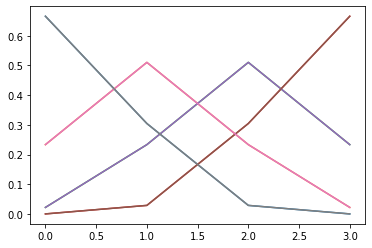

In [103]:
# visualization
import matplotlib.pyplot as plt

plt.plot(result1[0].T)
result1[0]

### - Soft_subscore version 2: resolution bigger than class number

In [114]:
config = {}
config['N_CLASSES'] = 4
config['N_SUBSCORES'] = 8
config['CLASSES_RESOLUTION'] = 28
config['STD'] = 5

result2 = get_soft_subscores(data['phq_subscores_gt'], config)  
result2.shape

torch.Size([2, 8, 28])

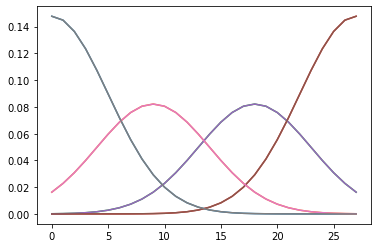

In [115]:
# plt.plot(result[0].T)
plt.plot(result2[0].T)
# result2[0]

In [25]:
tensor_a = torch.tensor([[2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
         [2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
         [6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04],
         [6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04],
         [6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04],
         [2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
         [2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
         [6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04]])

tensor_b = torch.tensor([[6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04],
         [2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
         [2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
         [2.2421e-02, 2.3364e-01, 5.1031e-01, 2.3364e-01],
         [2.2421e-02, 2.3364e-01, 5.1031e-01, 2.3364e-01],
         [2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
         [6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04],
         [6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04]])

tensor_c = torch.tensor([[2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
         [2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
         [6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04],
         [6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04],
         [6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04],
         [2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
         [2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
         [6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04]])


In [32]:
torch.cat([tensor_a, tensor_b], dim=0).view(-1, 8, 4)

tensor([[[2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
         [2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
         [6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04],
         [6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04],
         [6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04],
         [2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
         [2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
         [6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04]],

        [[6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04],
         [2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
         [2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
         [2.2421e-02, 2.3364e-01, 5.1031e-01, 2.3364e-01],
         [2.2421e-02, 2.3364e-01, 5.1031e-01, 2.3364e-01],
         [2.3364e-01, 5.1031e-01, 2.3364e-01, 2.2421e-02],
         [6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04],
         [6.6549e-01, 3.0468e-01, 2.9240e-02, 5.8818e-04]]])

### MUSDL Benchmark: result of converting the label to soft_scores

In [84]:
tensor = torch.tensor([0, 1, 2.5,  4.,  6.5, 7.5,  9, 10])
tensor

# example subscores from dataset

# [7.5 7.5 7.  7.  7.5 7.  7.5]
# [7.5 7.  7.5 7.  7.5 7.  7. ]
# [7.5 8.5 7.5 8.5 7.5 7.5 8. ]
# [6.5 6.5 6.5 6.5 7.  6.5 6.5]
# [6.  6.5 6.  6.5 6.  6.  6. ]
# [7.5 7.  7.  7.  7.  6.5 7. ]
# [9.  9.  9.  8.5 9.5 9.  9. ]
# [7.5 7.5 7.5 7.  8.  7.5 7.5]
# [7.5 7.  7.  7.  7.5 7.5 7. ]
# [8.5 8.5 8.5 8.5 8.5 8.5 8. ]
# [5.5 5.5 4.5 5.5 6.5 5.5 6. ]
# [8.5 9.  8.5 8.5 9.  8.5 9. ]
# [8.  8.  8.  8.5 8.  8.5 7.5]
# [7.  7.  6.5 7.5 6.5 7.5 7. ]
# [8.  8.  7.5 7.5 7.  7.5 7. ]


tensor([ 0.0000,  1.0000,  2.5000,  4.0000,  6.5000,  7.5000,  9.0000, 10.0000])

In [85]:
def proc_label(tensor):
    # Each judge choose a score from [0, 0.5, ..., 9.5, 10], we normalize it into 0~20
    tmp = [stats.norm.pdf(np.arange(21), loc=judge_score * (21-1) / 10, scale=5).astype(np.float32)
            for judge_score in tensor]
    tmp = np.stack(tmp)
    result = tmp / tmp.sum(axis=-1, keepdims=True)  # 7x21
    return result

In [86]:
test = proc_label(tensor)
test.shape

(8, 21)

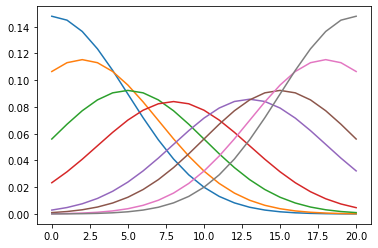

In [88]:
import matplotlib.pyplot as plt
plt.plot(test.T)

In [89]:
test[0]

array([1.47790805e-01, 1.44864351e-01, 1.36428118e-01, 1.23445265e-01,
       1.07318155e-01, 8.96396562e-02, 7.19375089e-02, 5.54675311e-02,
       4.10913602e-02, 2.92476118e-02, 2.00013127e-02, 1.31417988e-02,
       8.29620287e-03, 5.03190141e-03, 2.93233152e-03, 1.64180761e-03,
       8.83201254e-04, 4.56483773e-04, 2.26683129e-04, 1.08153676e-04,
       4.95782951e-05], dtype=float32)

# Test sentence Transformer

In [121]:
from sentence_transformers import SentenceTransformer
# sent2vec = SentenceTransformer('all-mpnet-base-v2')
# # start multi-processing
# SentenceTransformer.start_multi_process_pool(target_devices: List[str] = None)

text_path = os.path.join(os.getcwd(), 'DAIC-WOZ Dataset', '362_P', '362_TRANSCRIPT.csv')
pd.read_csv(text_path)

,start_time\tstop_time\tspeaker\tvalue
0,8.96\t11.93\tEllie\thi i'm ellie thanks for co...
1,12.67\t16.11\tEllie\ti was created to talk to ...
2,16.9\t23.37\tEllie\ti'm not a therapist but i'...
3,23.93\t28.64\tEllie\tand please feel free to t...
4,29.16\t30.47\tEllie\tare you okay with this
...,...
124,533\t534.1\tParticipant\ti like children
125,535.1\t535.8\tParticipant\tum
126,539.15\t541.41\tEllie\tokay i think i've asked...
127,542.15\t543.63\tEllie\tthanks for sharing your...


In [122]:
def load_text_file(text_path, speaker='Participant'):
    '''load transcript file and extract the text of the given speaker'''

    def tokenize_corpus(corpus):
        '''tokenzie a given list of string into list of words'''
        tokens = [x.split() for x in corpus]
        return tokens

    # only 'Ellie', 'Participant', 'both' are allow
    assert speaker in ['Ellie', 'Participant', 'both'], \
        "Argument --speaker could only be ['Ellie', 'Participant', 'both']"

    text_file = pd.read_csv(text_path)
    # tokenize the text file, filter out all \t space and unnecessary columns such as time, participent
    tokenized_words = tokenize_corpus(text_file.values.tolist()[i][0] for i in range(text_file.shape[0]))

    sentences = []
    sentences_idx = []

    if speaker == 'Ellie':
        for idx, sentence in enumerate(tokenized_words):
            if sentence[2] == 'Ellie':
                sentences.append(sentence[3:])
                sentences_idx.append(idx)
    elif speaker == 'Participant':
        for idx, sentence in enumerate(tokenized_words):
            if sentence[2] == 'Participant':
                sentences.append(sentence[3:])
                sentences_idx.append(idx)

    else:  # speaker == 'both'
        sentences = [tokenized_words[i][3:] for i in range(len(tokenized_words))]
        sentences_idx = list(range(len(tokenized_words)))

    # recombine 2D list of words into 1D list of sentence
    final_sentences = [" ".join(sentences[i]).lower() for i in range(len(sentences))]

    return final_sentences

In [123]:
final_sentences = load_text_file(text_path)

In [124]:
final_sentences

['yes',
 'good',
 'from california',
 'i like the eh arts and entertainments i like',
 'the uh',
 'you have a lot of freedom to work in a lot of different fields um',
 'i like the fact that the weather is great um i like the fact that all my roots are here all my family is here',
 "i don't like",
 "how hard it is to get places anymore it's very hard there's so much traffic it takes a long time to get where you're going um it's expensive it's a lot more expensive than it used to be",
 'not anymore',
 'i studied journalism english music and special effects makeup',
 'i am',
 'now i am managing a doggy day care facility',
 'my dream job is to',
 'own my own company again um',
 'probably working with animals',
 'no',
 "i'm i'm an artist i draw i paint i do tattoos",
 'i work a lot with animals',
 'i like outdoor activities biking hiking',
 "um people that aren't fair people that are",
 'angry and um people that are dishonest',
 'usually i will give myself like a ten second timeout and thin

In [125]:
len(final_sentences)

78

In [126]:
from transformers import AutoTokenizer, AutoModel
import torch

In [127]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [128]:
#Sentences we want sentence embeddings for
sentences = ['This framework generates embeddings for each input sentence',
             'Sentences are passed as a list of string.',
             'The quick brown fox jumps over the lazy dog.']

#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")

#Tokenize sentences
encoded_input = tokenizer(final_sentences, padding=True, truncation=True, max_length=256, return_tensors='pt')
print(encoded_input)

# #Compute token embeddings
# with torch.no_grad():
#     model_output = model(**encoded_input)
# # print(model_output)

# #Perform pooling. In this case, mean pooling
# sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

{'input_ids': tensor([[   0, 2752,    2,  ...,    1,    1,    1],
        [   0, 2208,    2,  ...,    1,    1,    1],
        [   0, 2017, 2666,  ...,    1,    1,    1],
        ...,
        [   0, 8533, 1049,  ...,    1,    1,    1],
        [   0, 1049, 2070,  ...,    1,    1,    1],
        [   0, 8533,    2,  ...,    1,    1,    1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [133]:
encoded_input['attention_mask'].shape

torch.Size([78, 50])

In [130]:
#Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

#Perform pooling. In this case, mean pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

In [131]:
sentence_embeddings.shape

torch.Size([78, 768])

# Confusion Matrix

In [39]:
from sklearn.metrics import confusion_matrix

In [48]:
def standard_confusion_matrix(gt, pred):
    """
    Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(np.asarray(gt), np.asarray(pred))
    return np.array([[tp, fp], [fn, tn]])

In [63]:
gt = [1,0,1,0,1]
pred = [1,1,0,1,1]
standard_confusion_matrix(gt, pred)

array([[2, 2],
       [1, 0]], dtype=int64)

In [59]:
[[tp, fp], [fn, tn]] = standard_confusion_matrix(gt, pred)

In [61]:
tp, fp, fn, tn

(2, 2, 1, 0)

# how the information is printed out in logger

In [160]:
print('-' * 54 + ' L + MUSDL ' + '-' * 54)
print('Epoch: 0  Current Best: 0 at epoch 0')

msg1 = '  End of {0}:\n  | time: {1:8.3f}s | LR: {2:8.5f} | Average Loss: {3:8.5f} | Accuracy: {4:5.2f}% ({5}/{6}) | {7} correlation: {8:8.6f} |'.format('train', 1468.05947, 00.059478, 0.409878, 0.8*100, int(80), int(100), 'train', -0.408248290463863)
print(msg1)

msg2 = '  End of {0}:\n  | time: {1:8.3f}s | LR: {2:8.5f} | Average Loss: {3:8.5f} | Accuracy: {4:5.2f}% ({5}/{6}) | {7} correlation: {8:8.6f} |'.format('valid', 1468.05947, 00.059478, 0.409878, 0.8*100, int(80), int(100), 'valid', -0.408248290463863)
print(msg2)

msg3 = ('\n  Output Scores:')
msg4 = ('  - Classification:\n      TPR/Sensitivity: {0:5.2f}\n      TNR/Specificity: {1:5.2f}\n      Precision: {2:5.2f}\n      Recall: {3:5.2f}\n      F1-score: {4:5.2f}').format(0.55555,0.55555,0.55555,0.55555,0.55555)
msg5 = ('  - Regression:\n      MAE: {0:5.2f}\n      MSE: {1:5.2f}\n      RMSE: {2:5.2f}\n      R2: {3:5.2f}').format(0.55555,0.55555,0.55555,0.55555)
print(msg3)
print(msg4)
print(msg5)

------------------------------------------------------ L + MUSDL ------------------------------------------------------
Epoch: 0  Current Best: 0 at epoch 0
  End of train:
  | time: 1468.059s | LR:  0.05948 | Average Loss:  0.40988 | Accuracy: 80.00% (80/100) | train correlation: -0.408248 |
  End of valid:
  | time: 1468.059s | LR:  0.05948 | Average Loss:  0.40988 | Accuracy: 80.00% (80/100) | valid correlation: -0.408248 |

  Output Scores:
  - Classification:
      TPR/Sensitivity:  0.56
      TNR/Specificity:  0.56
      Precision:  0.56
      Recall:  0.56
      F1-score:  0.56
  - Regression:
      MAE:  0.56
      MSE:  0.56
      RMSE:  0.56
      R2:  0.56


In [166]:
msg = ('  - Classification:\n'
       '      TPR/Sensitivity: {0:5.2f}\n'
       '      TNR/Specificity: {1:5.2f}\n'
       '      Precision: {2:5.2f}\n'
       '      Recall: {3:5.2f}\n'
       '      F1-score: {4:5.2f}').format(0.55555,0.55555,0.55555,0.55555,0.55555)

print(type(msg))

<class 'str'>


# TensorBoard Tutorial

In [1]:
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

In [2]:
# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('mnist_train', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
model = torchvision.models.resnet50(False)
# Have ResNet model take in grayscale rather than RGB
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
images, labels = next(iter(trainloader))

grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)
writer.add_graph(model, images)
writer.close()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_train\MNIST\raw\train-images-idx3-ubyte.gz to mnist_train\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_train\MNIST\raw\train-labels-idx1-ubyte.gz to mnist_train\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_train\MNIST\raw\t10k-images-idx3-ubyte.gz to mnist_train\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_train\MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist_train\MNIST\raw



In [ ]:
# run the following code in cmd
tensorboard --logdir=runs

In [3]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

# add_scala

writer = SummaryWriter()

for n_iter in range(100):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter)

In [4]:
# pr_curve

labels = np.random.randint(2, size=100)  # binary label
predictions = np.random.rand(100)
writer = SummaryWriter()
writer.add_pr_curve('pr_curve', labels, predictions, 0)
writer.close()

In [6]:
# add_scalars

writer = SummaryWriter()
r = 5
for i in range(100):
    writer.add_scalars('run_14h', {'xsinx':i*np.sin(i/r),
                                    'xcosx':i*np.cos(i/r),
                                    'tanx': np.tan(i/r)}, i)
writer.close()

# Debug ViT


In [129]:
from vit import ViT

from skimage import io, transform

In [97]:
# rescale image

def rescale(image, output_size):
    h, w = image.shape[:2]

    if isinstance(output_size, int):
        if h > w:
            new_h, new_w = output_size * h / w, output_size
        else:
            new_h, new_w = output_size, output_size * w / h
    else:
        new_h, new_w = output_size

    new_h, new_w = int(new_h), int(new_w)

    img = transform.resize(image, (new_h, new_w))

    return img

In [167]:
image = transformed_dataset[0]['sentence_embeddings']
image.shape

In [146]:
img = rescale(image[:102], (256, 256)).reshape((1,1,256, 256))
print(img.shape)
img

(1, 1, 256, 256)


array([[[[ 0.01223349, -0.00911181,  0.00822419, ...,  0.00410442,
          -0.02116271, -0.02657881],
         [ 0.01152719, -0.00885142,  0.00276996, ...,  0.00561038,
          -0.02334277, -0.02871415],
         [ 0.01291263, -0.00936219,  0.01346865, ...,  0.00265638,
          -0.01906649, -0.02452561],
         ...,
         [-0.02238797,  0.02008174,  0.00525289, ...,  0.0149739 ,
           0.00396261, -0.001725  ],
         [-0.02557177,  0.02132559,  0.0069953 , ...,  0.0268412 ,
          -0.00370663,  0.00898176],
         [-0.02394866,  0.02069147,  0.00610701, ...,  0.02079121,
           0.00020318,  0.00352341]]]])

In [137]:
model = ViT(image_size=256, patch_size=8, num_classes=1024, channels=1,
            dim=64, depth=6, heads=8, mlp_dim=128)
model.train()
output = model(torch.from_numpy(img).type(torch.FloatTensor))
output.shape

torch.Size([1, 1024])

In [151]:
img1 = rescale(image[:102], (256, 256)).reshape((1,256,256))
img2 = rescale(image, (256, 256)).reshape((1,256,256))

img = torch.stack([torch.from_numpy(img1), torch.from_numpy(img2)], dim=0).type(torch.FloatTensor)
img.shape

torch.Size([2, 1, 256, 256])

In [152]:
output = model(img)
output.shape

torch.Size([2, 512])

In [144]:
model = ViT(image_size=256, patch_size=8, num_classes=512, channels=1,
            dim=256, depth=6, heads=8, mlp_dim=512)
model.train()
output = model(img)
output.shape

torch.Size([2, 512])

In [ ]:
# model = ViT(
#     dim=128,
#     image_size=224,
#     patch_size=32,
#     num_classes=2,
#     transformer=efficient_transformer,
#     channels=3,
# ).to(device)

In [161]:
# random crop the image

image = transformed_dataset[0]['sentence_embeddings']
image.shape

def crop(image, output_size):

    h, w = image.shape[:2]
    new_h, new_w = output_size

    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)

    image = image[top:top + new_h, left:left + new_w]
    
    return image

crop_image = crop(rescale(image[:102], (256, 256)), (224, 224))
crop_image.shape

(224, 224)

In [182]:
import os
import numpy as np
import pandas as pd
from skimage import transform
from sentence_transformers import SentenceTransformer

import torch
from torch.utils.data import Dataset

# # local functions
# from utils import *


class DepressionDataset(Dataset):
    '''create a training, develop, or test dataset
       and load the participant features if it's called
    '''

    def __init__(self,
                 root_dir,
                 mode,
                 transform=None):
        super(DepressionDataset, self).__init__()

        # only train, develop, test dataset allow
        assert mode in ["train", "validation", "test"], \
            "Argument --mode could only be ['train', 'validation', 'test']"

        self.mode = mode
        self.root_dir = root_dir
        self.transform = transform
        self.train_data_path = os.path.join(self.root_dir, 'train_split_Depression_AVEC2017.csv')
        self.valid_data_path = os.path.join(self.root_dir, 'dev_split_Depression_AVEC2017.csv')
        self.test_data_path = os.path.join(self.root_dir, 'full_test_split.csv')
        # load sent2vec model for converting text file to 2D array
        self.sent2vec = SentenceTransformer('all-mpnet-base-v2')  # output dimension 768

        # load training data # 107 sessions
        if self.mode == "train":
            # pre-checking and cleaning the data
            self.data_df = self.pre_check(pd.read_csv(self.train_data_path))
            # store ground truth
            ####################################################################################################
            # self.patientIDs = self.data_df['Participant_ID'].to_numpy()
            self.patientIDs = np.array([303, 321, 362, 363, 426])  # for debugging on my laptop
            ####################################################################################################
            self.phq_binay_gt = self.data_df['PHQ8_Binary'].to_numpy()
            self.phq_score_gt = self.data_df['PHQ8_Score'].to_numpy()
            self.gender_gt = self.data_df['Gender'].to_numpy()
            self.phq_subscores_gt = self.data_df.iloc[:, 4:].to_numpy()

        # load development data # 35 sessions
        if self.mode == "validation":
            # pre-checking and cleaning the data
            self.data_df = self.pre_check(pd.read_csv(self.valid_data_path))
            # store ground truth
            self.patientIDs = self.data_df['Participant_ID'].to_numpy()
            self.phq_binay_gt = self.data_df['PHQ8_Binary'].to_numpy()
            self.phq_score_gt = self.data_df['PHQ8_Score'].to_numpy()
            self.gender_gt = self.data_df['Gender'].to_numpy()
            self.phq_subscores_gt = self.data_df.iloc[:, 4:].to_numpy()

        # load test data # 47 sessions
        if self.mode == "test":
            # pre-checking and cleaning the data
            self.data_df = self.pre_check(pd.read_csv(self.test_data_path))
            # store ground truth
            self.patientIDs = self.data_df['Participant_ID'].to_numpy()
            self.phq_binay_gt = self.data_df['PHQ_Binary'].to_numpy()
            self.phq_score_gt = self.data_df['PHQ_Score'].to_numpy()
            self.gender_gt = self.data_df['Gender'].to_numpy()
            self.phq_subscores_gt = None

    def pre_check(self, data):
        '''
        Basic cleaning process to make sure no missing value
        and that the sum of each PHQ subscore equals to PHQ score
        Argument:
            data: numpy array
        Return:
            data: numpy array with type "int"
        '''
        # make sure no NaN, Inf, -Inf
        if data.isin([np.nan, np.inf, -np.inf]).any(1).sum():
            print('Replacing NaN, Inf, or -Inf ...')
            data = data.replace([np.inf, -np.inf, np.nan], 0)  # .astype('int')
        else:
            data = data  # .astype('int')

        # compare the sum of each PHQ subscore to PHQ score
        unequal = data.iloc[:, 4:].sum(axis=1) != data.iloc[:, 2]
        if unequal.any() and self.mode != 'test':
            lines = np.where(unequal)
            raise ValueError(("The sum of each PHQ subscore at line {} "
                              "is unequal to the PHQ score").format(lines[0]))

        return data

    def __len__(self):
        return len(self.patientIDs)

    def __iter__(self):
        return iter(self.patientIDs)

    def __getitem__(self, idx):
        '''
        Essentional function for creating dataset in PyTorch, which will automatically be
        called in Dataloader and load all the extracted features of the patient in the Batch
        based on the index of self.patientIDs
        Argument:
            idx: int, index of the patient ID in self.patientIDs
        Return:
            session: dict, contains all the extracted features and ground truth of a patient/session
        '''
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # get the patient session path
        session_num = self.patientIDs[idx]
        session_path = os.path.join(self.root_dir, '{}_P'.format(session_num))

        # TODO: if other feature is needed, add more in the following part...

        # get text path
        text_path = os.path.join(session_path, '{}_TRANSCRIPT.csv'.format(session_num))

        # text feature
        self.text_feature = self.load_sent2vec(text_path, speaker='Participant')
        sentence_embedding = self.text_feature['sentence_embeddings']

        # summary
        session = {'patientID': session_num,
                   'session_path': session_path,
                   'sentence_embeddings': sentence_embedding,
                   'phq_score_gt': self.phq_score_gt[idx],
                   'phq_binay_gt': self.phq_binay_gt[idx],
                   'phq_subscores_gt': self.phq_subscores_gt[idx],
                   'gender_gt': self.gender_gt[idx]}

        if self.transform:
            session = self.transform(session)

        return session

    def load_sent2vec(self, text_path, speaker='Participant'):
        '''
        load the text file and use sent2vec model from SentenceTransformer
        for sentence embeddings, which generates 2D array
        Arguments:
            text_path: string, absolute path to transcipt file
            speaker: certain string, which transcript of the speaker to load
        Return:
            text_feature: dict, contain converted embedding vectors, sentences, etc.
        '''

        # only 'Ellie', 'Participant', 'both' are allow
        assert speaker in ['Ellie', 'Participant', 'both'], \
            "Argument --speaker could only be ['Ellie', 'Participant', 'both']"

        text_file = pd.read_csv(text_path)
        # tokenize the text file, filter out all \t space and unnecessary columns such as time, participent
        tokenized_words = self.tokenize_corpus(text_file.values.tolist()[i][0] for i in range(text_file.shape[0]))

        sentences = []
        sentences_idx = []

        if speaker == 'Ellie':
            for idx, sentence in enumerate(tokenized_words):
                if sentence[2] == 'Ellie':
                    sentences.append(sentence[3:])
                    sentences_idx.append(idx)
        elif speaker == 'Participant':
            for idx, sentence in enumerate(tokenized_words):
                if sentence[2] == 'Participant':
                    sentences.append(sentence[3:])
                    sentences_idx.append(idx)

        else:  # speaker == 'both'
            sentences = [tokenized_words[i][3:] for i in range(len(tokenized_words))]
            sentences_idx = list(range(len(tokenized_words)))

        # recombine 2D list of words into 1D list of sentence
        final_sentences = [" ".join(sentences[i]).lower() for i in range(len(sentences))]
        # convert sentence to vector with SentenceTransformer pretrained model
        sentence_embeddings = self.sent2vec.encode(final_sentences)

        # summary
        text_feature = {'speaker': speaker,
                        'sentence_embeddings': sentence_embeddings,
                        'sentences': final_sentences,
                        'indices': sentences_idx}

        return text_feature

    def tokenize_corpus(self, corpus):
        '''tokenzie a given list of string into list of words
        Argument:
            corpus: 1D list of string, each element is a sting of sentence
        Return:
            tokens: 2D list of string, each raw is a list of words splitted from sentence
        '''
        tokens = [x.split() for x in corpus]
        return tokens


class Padding(object):
    ''' pad zero to each feature matrix so that they all have the same size '''

    def __init__(self, text_output_size=(386, 768)):
        super(Padding, self).__init__()
        '''
        Each output size could be 'int' or 'tuple'. 
        Integer would be the number of desired rows
        and Tuple would be the desired 2D array size.

        Here is recommended to keep the number of columns 
        as they are and only set the number of rows with int

        To find the maximum length of rows, please use the 
        'find_max_length' function in utils to search through. 

        The value 386 are the maximum length in our case.
        '''
        assert isinstance(text_output_size, (int, tuple))
        self.text_output_size = text_output_size

    def __call__(self, session):
        sentence_embeddings = session['sentence_embeddings']

        # text padding
        if isinstance(self.text_output_size, int):
            shape = sentence_embeddings.shape
            assert self.text_output_size >= shape[0], \
                "audio output size should be bigger than {}".format(shape[0])
            padded_text = np.zeros((self.text_output_size, shape[1]))
            padded_text[:shape[0], :shape[1]] = sentence_embeddings
        else:
            shape = sentence_embeddings.shape
            assert self.text_output_size[0] >= shape[0] and self.text_output_size[1] >= shape[1], \
                "text output size should be bigger than {}".format(shape)
            padded_text = np.zeros(self.text_output_size)
            padded_text[:shape[0], :shape[1]] = sentence_embeddings

        # summary
        padded_session = {'patientID': session['patientID'],
                          'session_path': session['session_path'],
                          'sentence_embeddings': padded_text,
                          'phq_score_gt': session['phq_score_gt'],
                          'phq_binay_gt': session['phq_binay_gt'],
                          'phq_subscores_gt': session['phq_subscores_gt'],
                          'gender_gt': session['gender_gt']}

        return padded_session


class Rescale(object):
    """Rescale the image in a sample to a given size.
    Arguments:
        output_size:(tuple or int),  Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size=(256, 256)):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, session):
        sentence_embeddings = session['sentence_embeddings'].squeeze()  # 2D = (sentences number x 768)

        h, w = sentence_embeddings.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        rescaled_sentence_embeddings = transform.resize(sentence_embeddings, (new_h, new_w))

        # summary
        rescaled_session = {'patientID': session['patientID'],
                            'session_path': session['session_path'],
                            'sentence_embeddings': rescaled_sentence_embeddings.reshape(1, new_h, new_w),
                            'phq_score_gt': session['phq_score_gt'],
                            'phq_binay_gt': session['phq_binay_gt'],
                            'phq_subscores_gt': session['phq_subscores_gt'],
                            'gender_gt': session['gender_gt']}

        return rescaled_session


class RandomCrop(object):
    """Crop randomly the image in a sample.
    Arguments:
        output_size:(tuple or int), Desired output size. If int, square crop
            is made.
    """
    def __init__(self, output_size=(224, 224)):
        assert isinstance(output_size, (int, tuple))

        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, session):
        sentence_embeddings = session['sentence_embeddings'].squeeze()
        
        h, w = sentence_embeddings.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        cropped_sentence_embeddings = sentence_embeddings[top:top + new_h, left:left + new_w]

        # summary
        cropped_session = {'patientID': session['patientID'],
                           'session_path': session['session_path'],
                           'sentence_embeddings': cropped_sentence_embeddings.reshape(1, new_h, new_w),
                           'phq_score_gt': session['phq_score_gt'],
                           'phq_binay_gt': session['phq_binay_gt'],
                           'phq_subscores_gt': session['phq_subscores_gt'],
                           'gender_gt': session['gender_gt']}

        return cropped_session


class ToTensor(object):
    """Convert ndarrays in sample to Tensors or np.int to torch.tensor."""

    def __call__(self, session):

        converted_session = {'patientID': session['patientID'],
                             'session_path': session['session_path'],
                             'sentence_embeddings': torch.from_numpy(session['sentence_embeddings']).type(torch.FloatTensor),
                             'phq_score_gt': torch.tensor(session['phq_score_gt']).type(torch.FloatTensor),
                             'phq_binay_gt': torch.tensor(session['phq_binay_gt']).type(torch.FloatTensor),
                             'phq_subscores_gt': torch.from_numpy(session['phq_subscores_gt']).type(torch.FloatTensor),
                             'gender_gt': torch.tensor(session['gender_gt']).type(torch.FloatTensor)}

        return converted_session

In [183]:
import sys
from torch.utils.data import DataLoader
from torchvision import transforms

# sys.path.append('C:/Users/denni/Documents/KIT Studium/Bachelorarbeit')
root_dir = 'C:/Users/denni/Documents/KIT Studium/Bachelorarbeit'

# test 3: try to load the dataset with DataLoader
transformed_dataset = DepressionDataset(os.path.join(root_dir, 'DAIC-WOZ Dataset'), 'train',
                                        transform=transforms.Compose([Rescale((256, 256)),
                                                                      RandomCrop((224, 224)),
                                                                      ToTensor()]))

# create dataloader
dataloader = DataLoader(transformed_dataset,
                        batch_size=2,
                        shuffle=False,
                        num_workers=0)
# iterate through batches
for i_batch, sample_batched in enumerate(dataloader):
    print('Batch number: ', i_batch, ', sentence embeddings: ', sample_batched['sentence_embeddings'].size())
    print('=================================')

Batch number:  0 , sentence embeddings:  torch.Size([2, 1, 224, 224])
Batch number:  1 , sentence embeddings:  torch.Size([2, 1, 224, 224])
Batch number:  2 , sentence embeddings:  torch.Size([1, 1, 224, 224])


In [16]:
torch.tensor([0.99, 1.99, 2.99, 3.99]).type(torch.int)  # .to(int)

tensor([0, 1, 2, 3], dtype=torch.int32)

In [23]:
a = torch.tensor([0.99, 1.99, 2.99, 3.99]).to(int).to(float)

In [24]:
a

tensor([0., 1., 2., 3.], dtype=torch.float64)

# Debug BiLSTM

In [28]:
import torch
import torch.nn as nn
from torch.nn import functional as F


class BiLSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layer, dropout, bidirectional):
        super(BiLSTM, self).__init__()
        self.embedding_size = input_dim         # 768 
        self.num_class = output_dim             # 768
        self.hidden_dim = hidden_dim            # 256
        self.rnn_layers = num_layer             # 2 or 4
        self.dropout = dropout                  # 0.2
        self.bidirectional = bidirectional      # True

        self.build_model()
        self.init_weight()
        
    def init_weight(net):
        for name, param in net.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                nn.init.xavier_uniform_(param)

    def build_model(self):
        # attention layer
        self.attention_layer = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(inplace=True)
        )

        # lstm layer
        self.lstm_net = nn.LSTM(self.embedding_size, self.hidden_dim,
                                num_layers=self.rnn_layers, dropout=self.dropout,
                                bidirectional=self.bidirectional)
        
        # FC layer
        self.fc_out = nn.Sequential(
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden_dim, self.num_class),
            nn.ReLU(),
        )

    def attention_net_with_w(self, lstm_out, lstm_hidden):
        '''
        :param lstm_out:    [batch_size, len_seq, n_hidden * 2]
        :param lstm_hidden: [batch_size, num_layers * num_directions, n_hidden]
        :return: [batch_size, n_hidden]
        '''
        lstm_tmp_out = torch.chunk(lstm_out, 2, -1)
        # h [batch_size, time_step, hidden_dims]
        h = lstm_tmp_out[0] + lstm_tmp_out[1]
        # [batch_size, num_layers * num_directions, n_hidden]
        lstm_hidden = torch.sum(lstm_hidden, dim=1)
        # [batch_size, 1, n_hidden]
        lstm_hidden = lstm_hidden.unsqueeze(1)
        # atten_w [batch_size, 1, hidden_dims]
        atten_w = self.attention_layer(lstm_hidden)
        # m [batch_size, time_step, hidden_dims]
        m = nn.Tanh()(h)
        # atten_context [batch_size, 1, time_step]
        atten_context = torch.bmm(atten_w, m.transpose(1, 2))
        # softmax_w [batch_size, 1, time_step]
        softmax_w = F.softmax(atten_context, dim=-1)
        # context [batch_size, 1, hidden_dims]
        context = torch.bmm(softmax_w, h)
        result = context.squeeze(1)
        return result

    def forward(self, x):
        # x : [len_seq, batch_size, embedding_dim]
        x = x.permute(1, 0, 2)
        output, (final_hidden_state, final_cell_state) = self.lstm_net(x)
        # output : [batch_size, len_seq, n_hidden * 2]
        output = output.permute(1, 0, 2)
        # final_hidden_state : [batch_size, num_layers * num_directions, n_hidden]
        final_hidden_state = final_hidden_state.permute(1, 0, 2)
        atten_out = self.attention_net_with_w(output, final_hidden_state)
        return self.fc_out(atten_out)

In [29]:
bilstm = BiLSTM(input_dim=768,
                hidden_dim=512, 
                output_dim=768, 
                num_layer=4, 
                dropout=0.2, 
                bidirectional=True)

In [30]:
model_input = torch.randn(2, 10, 768)

In [32]:
result = bilstm(model_input)

In [33]:
result.shape

torch.Size([2, 768])

In [34]:
import transformers

In [35]:
bert = transformers.BertModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Debug Universal Sentence Transformer

universal-sentence-encoder: https://tfhub.dev/google/universal-sentence-encoder/4

universal-sentence-encoder-large: https://tfhub.dev/google/universal-sentence-encoder-large/5

In [5]:
import os
import numpy as np 
import pandas as pd

In [2]:
import tensorflow_hub as hub

In [3]:
# def sentence_embedding(text_df, model):
#     sentences = []
#     for t in text_df.itertuples():
#         if getattr(t, 'speaker') == 'Participant':
#             if 'scrubbed_entry' in getattr(t,'value'):
#                 continue
#             else:
#                 sentences.append(getattr(t, 'value'))
    
#     return model.encode(sentences)

def sentence_embedding(text_df):
    sentences = []
    for t in text_df.itertuples():
        if getattr(t, 'speaker') == 'Participant':
            if 'scrubbed_entry' in getattr(t,'value'):
                continue
            else:
                sentences.append(getattr(t, 'value'))
    
    return sentences



In [6]:
patient_ID = 362
text_path = os.path.join(os.getcwd(), 'DAIC-WOZ Dataset', f'{patient_ID}_P', f'{patient_ID}_TRANSCRIPT.csv')
text_df = pd.read_csv(text_path, sep='\t').fillna('')
text_df.head(10)

,start_time,stop_time,speaker,value
0,8.96,11.93,Ellie,hi i'm ellie thanks for coming in today
1,12.67,16.11,Ellie,i was created to talk to people in a safe and ...
2,16.90,23.37,Ellie,i'm not a therapist but i'm here to learn abou...
3,23.93,28.64,Ellie,and please feel free to tell me anything your ...
4,29.16,30.47,Ellie,are you okay with this
5,30.91,31.37,Participant,yes
6,32.84,34.90,Ellie,so how are you doing today
7,35.39,35.78,Participant,good
8,37.33,38.50,Ellie,where are you from originally
9,39.44,40.33,Participant,from california


In [14]:
sentences = sentence_embedding(text_df)
sentences[:20]

['yes ',
 'good ',
 'from california ',
 'i like the eh arts and entertainments i like',
 'the uh',
 'you have a lot of freedom to work in a lot of different fields um',
 'i like the fact that the weather is great um i like the fact that all my roots are here all my family is here  ',
 "i don't like",
 "how hard it is to get places anymore it's very hard there's so much traffic it takes a long time to get where you're going um it's expensive it's a lot more expensive than it used to be  ",
 'not anymore ',
 'i studied journalism english music and special effects makeup ',
 'i am ',
 'now i am managing a doggy day care facility ',
 'my dream job is to ',
 'own my own company again um',
 'probably working with animals ',
 'no',
 "i'm i'm an artist i draw i paint i do tattoos",
 'i work a lot with animals',
 'i like outdoor activities biking hiking  ']

### Test universal-sentence-encoder

In [8]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed(sentences)
print(embeddings.shape, type(embeddings))
embeddings[:5]

(77, 512) <class 'tensorflow.python.framework.ops.EagerTensor'>


<tf.Tensor: shape=(5, 512), dtype=float32, numpy=
array([[ 0.00931179, -0.03993654,  0.04903579, ..., -0.05920121,
        -0.01194051, -0.02619826],
       [-0.0444302 , -0.07187285,  0.01583888, ..., -0.04185356,
         0.01108887, -0.0329297 ],
       [-0.02419742,  0.01430838,  0.00765016, ...,  0.02361106,
         0.01626514, -0.00993789],
       [ 0.04398917, -0.05413452,  0.08918855, ..., -0.02764365,
         0.06124182, -0.06047855],
       [-0.0489117 , -0.03056137, -0.01177089, ..., -0.07055238,
         0.06200078,  0.02261064]], dtype=float32)>

In [13]:
embed_large = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")
embeddings_large = embed_large(sentences)

# convert from EagerTensor to numpy
embeddings_large = embeddings_large.numpy()

print(embeddings_large.shape, type(embeddings_large))
embeddings_large[:5]

(77, 512) <class 'numpy.ndarray'>


array([[-0.05881099,  0.01910839,  0.01972206, ..., -0.01062876,
         0.0303918 , -0.0292912 ],
       [-0.02128776,  0.01480258,  0.02107059, ...,  0.01610595,
        -0.06105837, -0.03500807],
       [ 0.05227029,  0.05979312, -0.02633224, ..., -0.00835546,
         0.0134875 , -0.02929783],
       [ 0.06404437,  0.04930337,  0.03336997, ..., -0.01074252,
         0.00155322,  0.04546057],
       [ 0.05585645,  0.00434221,  0.02867533, ...,  0.00405687,
        -0.10774966,  0.00071531]], dtype=float32)